In [41]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

By referencing the pytorch implementation:

- For 'linear', we keep the same learning rate for the first <opt.niter> epochs and linearly decay the rate to zero over the next <opt.niter_decay> epochs.
- --niter == 100 # of iter at starting learning rate 
- --niter_decay == 100  # of iter to linearly decay learning rate to zero
- --lr_decay_iters is ignored

In [33]:
def learning_rate_scheduler(epoch, niter, niter_decay):
    niter = 100
    niter_decay = 100
    lr_mult = 1.0 - max(0, epoch + 1 - niter) / float(niter_decay + 1)
    return lr_mult

Text(0, 0.5, 'lr_mult')

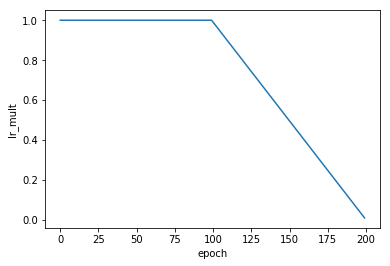

In [34]:
epochs = list(range(200))
lrs = [learning_rate_scheduler(e, 100, 100) for e in epochs]

plt.plot(epochs, lrs)
plt.xlabel('epoch')
plt.ylabel('lr_mult')

We can't use Keras' `LearningRateScheduler` callback because we're using the train_on_batch api which doesn't accept callbacks. Therefore we need class to return current learning rate so we can update it.

In [60]:
class LrSchedule():
    """
    keep the same learning rate for the first <niter> epochs 
    and linearly decay the rate to zero over the next <niter_decay> epochs
    
    
             | ________________
             |                 \
             |                  \
          lr |                   \
             |                    \
             |--------------------------
                       epochs

    - init_lr: the initial learning rate
    - decay_start: number of epochs before learning rate reduction begins
    - decay_end: the epoch on which learning rate reaches zero
    
    """
    
    def __init__(self, init_lr: float, decay_start: int, decay_end: int):
        # linear so stepsize is constant
        self.init_lr = init_lr
        self.lr_step = init_lr / decay_end
        self.decay_start = decay_start
        

    def update(self, epoch: int):
        if epoch < self.decay_start:
            return self.init_lr
        else:
            return self.init_lr - (self.lr_step * (epoch - self.decay_start))

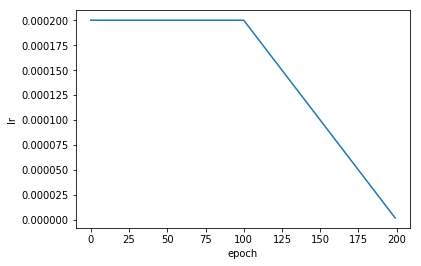

In [61]:
lr = 0.0002
lr_decay_start = 100
lr_decay_end = 100

lr_schedule = LrSchedule(lr, lr_decay_start, lr_decay_end)

lrs = []
epochs = list(range(200))
for e in epochs:
    lr = lr_schedule.update(e)
    lrs.append(lr)

plt.plot(epochs, lrs)
plt.xlabel('epoch')
plt.ylabel('lr');

## Delete above if this works

In [68]:
def gen_lr_schedule(lr_init, decay_start, decay_end, steps_per_epoch):
    """ """
    def get_lr(current_epoch, final_epoch, lr_init):
        return lr_init - ((lr_init / final_epoch) * current_epoch)
    
    decay_interval = decay_end - decay_start + 1
    epochs = np.arange(1, decay_interval, dtype=np.int32)
    boundaries = list(steps_per_epoch * (epochs + decay_start))[:-1]
    values = [get_lr(e, decay_interval, lr_init) for e in epochs]
    return boundaries, values

In [69]:
lr = 0.0002
lr_decay_start = 100
lr_decay_end = 200
n_samples = 400
boundaries, values = gen_lr_schedule(lr, lr_decay_start, lr_decay_end, n_samples)

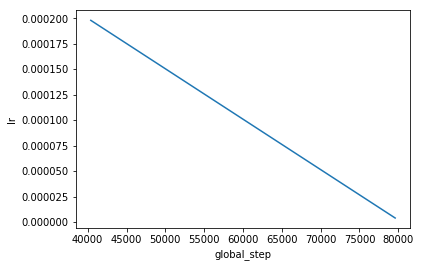

In [70]:
plt.plot(boundaries, values[:-1])
plt.xlabel('global_step')
plt.ylabel('lr');

In [57]:
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.piecewise_constant(global_step, boundaries, values)


<tf.Tensor 'PiecewiseConstant_3/case/cond/Merge:0' shape=() dtype=float64>